# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import os
import torch
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler


num_workers = 0
batch_size = 20
valid_size = 0.2

data_dir = '/data/landmark_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(), # randomly crop, flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


test_transform = transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



train_data = datasets.ImageFolder(train_dir, transform = train_transform) #augmentation used for training
valid_data = datasets.ImageFolder(train_dir, transform = test_transform)
test_data = datasets.ImageFolder(test_dir, transform = test_transform)

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, sampler=valid_sampler,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}



**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:

- Images are resized to 32 using interpolation (validation and test data) and random crops (training data). This size was chosen to reduce burden during training despite image resolution is changed so the CNN model takes an image tensor of size (32x32) as input .

- For data augmentation, I performed random horizontal flips and rotations of 10 degrees to add positional variety to the training images and so the model will be more robust at training process. Images are also cropped to a random area to train the network on fine details and then resized to size of 32.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

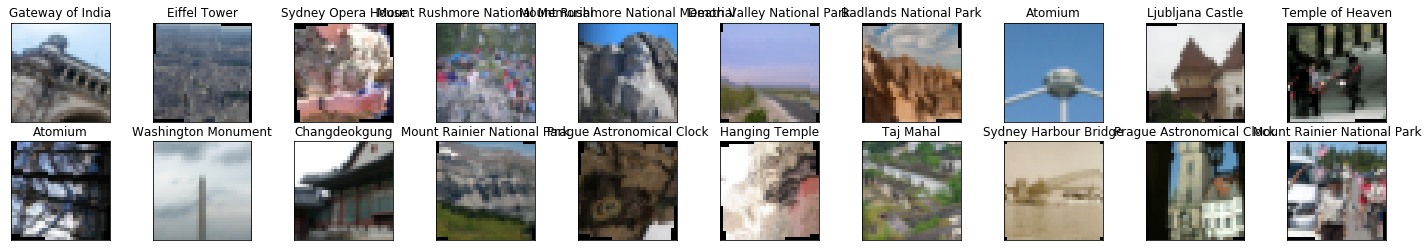

In [2]:
import matplotlib.pyplot as plt
import re
%matplotlib inline

## TODO: visualize a batch of the train data loader
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

cl = train_data.classes
classes = []

#Label transformation
for i in range(len(cl)):
    trans1 = re.sub('_',' ', cl[i])
    trans2 = re.sub('\d+.','', trans1)
    classes.append(trans2)

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 


fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    images[idx] = images[idx] / 2 + 0.5
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])



### Initialize use_cuda variable

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [7]:
## TODO: select loss function
import torch.nn as nn
import torch.optim as optim

criterion_scratch =  nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    return optim.SGD(model.parameters(), lr=0.01)
    
    ## TODO: select and return an optimizer

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [8]:
import torch.nn.functional as F
# define the CNN architecture


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 50)
        self.dropout = nn.Dropout(0.25)
        

    def forward(self, x):

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x
    
#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

Firstly, I included 3 convolutional layers to detect enough patterns in color and shape from the input images. The first one expects a 32x32x3 image tensor as input, and then it is convolved with 16 filters of size 3x3 resulting in a tensor of dimension 32x32x16. To keep the same input spatial dimensions, a padding of 1 is added. Next, a Relu activation function (to remove linearity) and a pooling layer with kernel size of 2x2 and stride of 2 are applied so that the resulting image dimension is reduced to 16x16x16. The same process is performed, involving a convolution operation with 32 filters of size 3, followed by another Relu function and a second pooling layer with kernel size of 2 and stride of 2 to produce a tensor of dimension 8x8x32. The final convolutional layer sees this tensor and creates 64 different filters of size 3 and joins another Relu and pooling layer, so image dimension is reduced to 4x4x64.

The next few layers are 2 fully conected linear layers. The first one receives the flattened tensor (4x4x64), with a dropout function to randomly set neurons to 0 at each update in the training stage to avoid overfitting, with 500 nodes as output applying a Relu activation function. Finally, the last linear layer will produce the output for the 50 possible classes corresponding to the different locations in the dataset.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))


        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))


            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model '.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        

    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [29]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__

    if classname.find('Linear') != -1 :
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
    
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.914806 	Validation Loss: 3.912290
Validation loss decreased (inf --> 3.912290).  Saving model 
Epoch: 2 	Training Loss: 3.911050 	Validation Loss: 3.911360
Validation loss decreased (3.912290 --> 3.911360).  Saving model 
Epoch: 3 	Training Loss: 3.908107 	Validation Loss: 3.909784
Validation loss decreased (3.911360 --> 3.909784).  Saving model 
Epoch: 4 	Training Loss: 3.905218 	Validation Loss: 3.905282
Validation loss decreased (3.909784 --> 3.905282).  Saving model 
Epoch: 5 	Training Loss: 3.899585 	Validation Loss: 3.898198
Validation loss decreased (3.905282 --> 3.898198).  Saving model 
Epoch: 6 	Training Loss: 3.888620 	Validation Loss: 3.881734
Validation loss decreased (3.898198 --> 3.881734).  Saving model 
Epoch: 7 	Training Loss: 3.867062 	Validation Loss: 3.846848
Validation loss decreased (3.881734 --> 3.846848).  Saving model 
Epoch: 8 	Training Loss: 3.842573 	Validation Loss: 3.808602
Validation loss decreased (3.846848 --> 3.808602).  Sav

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [33]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.912588 	Validation Loss: 3.912205
Validation loss decreased (inf --> 3.912205).  Saving model 
Epoch: 2 	Training Loss: 3.911343 	Validation Loss: 3.912053
Validation loss decreased (3.912205 --> 3.912053).  Saving model 
Epoch: 3 	Training Loss: 3.910916 	Validation Loss: 3.911882
Validation loss decreased (3.912053 --> 3.911882).  Saving model 
Epoch: 4 	Training Loss: 3.909637 	Validation Loss: 3.911399
Validation loss decreased (3.911882 --> 3.911399).  Saving model 
Epoch: 5 	Training Loss: 3.908509 	Validation Loss: 3.910359
Validation loss decreased (3.911399 --> 3.910359).  Saving model 
Epoch: 6 	Training Loss: 3.906325 	Validation Loss: 3.908252
Validation loss decreased (3.910359 --> 3.908252).  Saving model 
Epoch: 7 	Training Loss: 3.902117 	Validation Loss: 3.904139
Validation loss decreased (3.908252 --> 3.904139).  Saving model 
Epoch: 8 	Training Loss: 3.895747 	Validation Loss: 3.895713
Validation loss decreased (3.904139 --> 3.895713).  Sav

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [34]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.695962


Test Accuracy: 32% (406/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [4]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

num_workers = 0
batch_size = 20
valid_size = 0.2

data_dir = '/data/landmark_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # randomly crop, flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


test_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



train_data = datasets.ImageFolder(train_dir, transform = train_transform) #augmentation used for training
valid_data = datasets.ImageFolder(train_dir, transform = test_transform)
test_data = datasets.ImageFolder(test_dir, transform = test_transform)

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)



train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, sampler=valid_sampler,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}




### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [9]:
## TODO: select loss function

criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    return optim.SGD(model.fc.parameters(), lr=0.01)

    ## TODO: select and return optimizer

    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [10]:
## TODO: Specify model architecture

model = models.resnet50(pretrained=True)


for param in model.parameters():
    param.requires_grad = False


model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 50))


model_transfer = model

    
#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 62630231.52it/s]


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

For this transfer learning task, I used as pretrained model a ResNet50 network which is trained on a million images from the ImageNet database and can classify images into 1000 object categories. The idea is to keep all the convolutional layers by freezing all parameters so the pretrained model will not change during training and replace the last fully conected layer with two fully conected classifier layers. The first one takes the same number of inputs as the original one and produces 128 outputs for each neuron, with a Relu activation function applied on top of that to get sparse representations and faster learning. This number of neurons was selected to have the size between 2048 and 50 (number of outputs). The second layer takes those 128 inputs and produces 50 outputs, corresponding to each class.

The architecture is suitable for this problem because ResNet uses residual blocks that allow alternate shortcut paths or skip connections for the gradient to flow through and helps the model to learn identity functions so higher layers perform as good as lower ones. With this, we make sure that performance does not degrade in the deeper layers, where the model needs to learn more complex features. This architecture is adapted to the problem by modifying the final fully conected layer to produce 50 outputs.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [15]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
model_transfer = train(10, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
      criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 3.829603 	Validation Loss: 3.672306
Validation loss decreased (inf --> 3.672306).  Saving model 
Epoch: 2 	Training Loss: 3.550974 	Validation Loss: 3.242418
Validation loss decreased (3.672306 --> 3.242418).  Saving model 
Epoch: 3 	Training Loss: 3.157854 	Validation Loss: 2.783710
Validation loss decreased (3.242418 --> 2.783710).  Saving model 
Epoch: 4 	Training Loss: 2.759520 	Validation Loss: 2.375278
Validation loss decreased (2.783710 --> 2.375278).  Saving model 
Epoch: 5 	Training Loss: 2.448274 	Validation Loss: 2.075647
Validation loss decreased (2.375278 --> 2.075647).  Saving model 
Epoch: 6 	Training Loss: 2.227753 	Validation Loss: 1.907929
Validation loss decreased (2.075647 --> 1.907929).  Saving model 
Epoch: 7 	Training Loss: 2.050972 	Validation Loss: 1.738913
Validation loss decreased (1.907929 --> 1.738913).  Saving model 
Epoch: 8 	Training Loss: 1.911838 	Validation Loss: 1.611355
Validation loss decreased (1.738913 --> 1.611355).  Sav

In [18]:
if use_cuda:
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

checkpoint = torch.load('model_transfer.pt', map_location=map_location)
model_transfer.load_state_dict(checkpoint)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [19]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.390682


Test Accuracy: 64% (805/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [26]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    
    transform = transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    img = Image.open(img_path)
    
    img_tr = transform(img)
    
    batch_img = torch.unsqueeze(img_tr, 0)
    
    model_transfer.eval()
    x = model_transfer(batch_img)

    output = torch.exp(x)/torch.sum(torch.exp(x))
    _ , indices = output.topk(k)
    preds = np.squeeze(indices.numpy())
    locations = []
    for i in preds:
        locations.append(classes[i])
    return locations
    


    
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Forth Bridge',
 'Sydney Opera House',
 'Brooklyn Bridge',
 'Sydney Harbour Bridge']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Possible locations: 

1.Golden Gate Bridge
2.Forth Bridge
3.Sydney Opera House


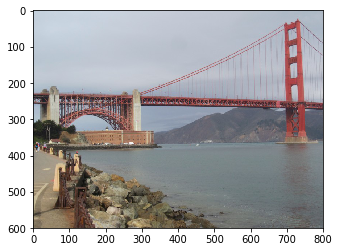

In [27]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    img = Image.open(img_path)
    plt.imshow(img)
    print("Possible locations: ")
    print("")
    
    c = 1
    for loc in predicted_landmarks:
        print(str(c) +"."+loc)
        c += 1

        
    ## TODO: display image and display landmark predictions

    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

Overall, I can say the model performed better than expected when passing some images in my computer. For the 5 of them, 4 had  the correct location among the top 3 suggestions meaning that the algorithm has learned some of the features and patterns that identify each place. This can also be verified by looking at the other suggestions, which seem very similar in terms of style, theme and color to the actual location. For instance, when predicting Niagara Falls, other natural destinations are displayed like Gullfoss Falls and Banff National Park.

To improve the algorithm, I could have added more dense layers at the end to obtain a deeper network topology to learn more features at various levels of abstraction, although it will take longer time to train. Also, by training the model with higher number of epochs until it overfits on the validation set, with the aim to improve accuracy, and stop learning once performance starts to reduce, saving time. Another point was to try different weight initialization methods to see which one does better or even different activation functions. 

Possible locations: 

1.Vienna City Hall
2.Temple of Olympian Zeus
3.Stockholm City Hall


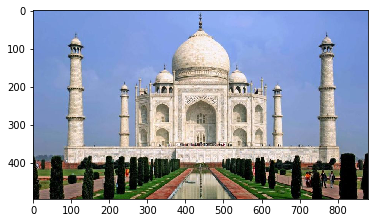

In [28]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

suggest_locations('taj_mahal.jpg')



Possible locations: 

1.Eiffel Tower
2.Terminal Tower
3.Vienna City Hall


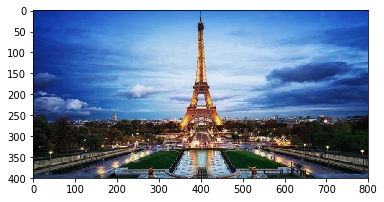

In [29]:
suggest_locations('eiffel_tower.jpg')

Possible locations: 

1.Gullfoss Falls
2.Niagara Falls
3.Banff National Park


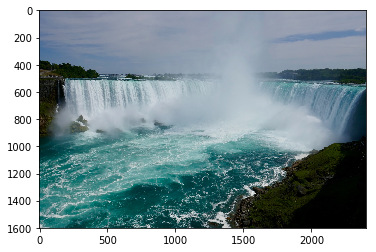

In [30]:
suggest_locations('niagara_falls.jpg')

Possible locations: 

1.Temple of Olympian Zeus
2.Sydney Opera House
3.Petronas Towers


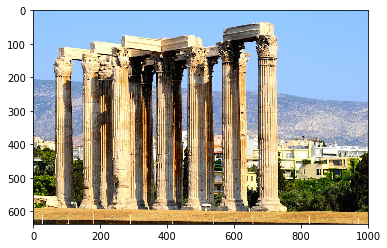

In [31]:
suggest_locations('templo-zeus.jpg')

Possible locations: 

1.Atomium
2.London Olympic Stadium
3.Sydney Opera House


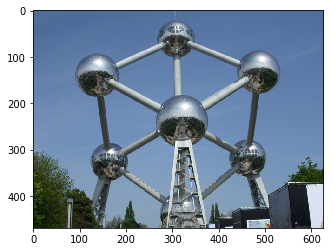

In [32]:
suggest_locations('atomium_belgium.jpg')